In [1]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import talib

In [7]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%Y-%m-%d %H:%M:%S'
        self.column_names = ['day', 'month', 'year', 'hour', 'minute', 'second', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, date.hour, date.minute, date.second, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [8]:
luv = FileInstrument('../../../Developer/Data/FirstRateData/DIA_2000_2009.txt')

In [9]:
d = np.diff(luv['close'], prepend=luv['close'][0])

In [10]:
luv.attach_feature(d, 'back_returns')

In [11]:
luv['back_returns']

array([ 0.  , -0.02, -0.04, ...,  0.  ,  0.  ,  0.  ])

In [116]:
def run_monte_single(asset, idx, samples=70000, simulations=1000):
    returns = asset['forward_returns'][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [117]:
mc = run_monte_single(luv, luv['back_returns'] < talib.EMA(luv['back_returns']))

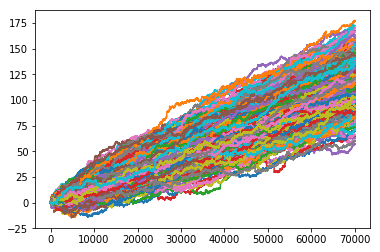

In [118]:
plt.plot(mc.T)

In [119]:
vanilla = run_monte_single(luv, np.random.choice([True, False], size=len(luv[:,0]), p=[1, 0]))

(array([ 2.,  1.,  1.,  1.,  1.,  1.,  2.,  0.,  2., 12.,  9., 19., 14.,
        20., 20., 31., 21., 37., 36., 37., 40., 48., 47., 52., 57., 53.,
        47., 44., 41., 48., 39., 39., 32., 35., 21., 18., 18., 11., 14.,
         4.,  8.,  2.,  4.,  3.,  0.,  2.,  2.,  2.,  1.,  1.]),
 array([ 56.8233  ,  59.231276,  61.639252,  64.047228,  66.455204,
         68.86318 ,  71.271156,  73.679132,  76.087108,  78.495084,
         80.90306 ,  83.311036,  85.719012,  88.126988,  90.534964,
         92.94294 ,  95.350916,  97.758892, 100.166868, 102.574844,
        104.98282 , 107.390796, 109.798772, 112.206748, 114.614724,
        117.0227  , 119.430676, 121.838652, 124.246628, 126.654604,
        129.06258 , 131.470556, 133.878532, 136.286508, 138.694484,
        141.10246 , 143.510436, 145.918412, 148.326388, 150.734364,
        153.14234 , 155.550316, 157.958292, 160.366268, 162.774244,
        165.18222 , 167.590196, 169.998172, 172.406148, 174.814124,
        177.2221  ]),
 <a list of 50

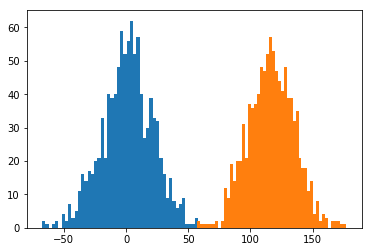

In [124]:
plt.hist(vanilla[:,-1], bins=50)
plt.hist(mc[:,-1], bins=50)

In [113]:
strat = luv['back_returns'] < talib.EMA(luv['back_returns'])

In [114]:
performance = strat.astype(int) * luv['forward_returns']

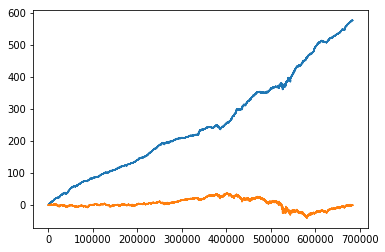

In [115]:
plt.plot(np.cumsum(performance))
plt.plot(np.cumsum(luv['forward_returns']))

In [96]:
time_in_market = np.sum(strat.astype(int)) / len(strat)

In [97]:
strat_perf = np.cumsum(performance)
buy_hold_perf = np.cumsum(luv['forward_returns'])

In [98]:
strat_v_bh = strat_perf[-1] / buy_hold_perf[-1]

In [99]:
print(f'Time in the market: \t\t{time_in_market*100:.2f}%')
print(f'Performance against BH: \t{strat_v_bh*100:.2f}%')
print(f'Volatility efficiency: \t\t{(strat_v_bh / time_in_market)*100:.2f}%')

Time in the market: 		50.35%
Performance against BH: 	-55284.83%
Volatility efficiency: 		-109800.98%


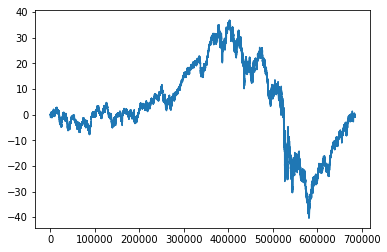

In [83]:
plt.plot(np.cumsum(luv['forward_returns']))